**Fiche d'exercice n°1**

Cette fiche d'exercices doit permettre de :
- s'entraîner au devoir de janvier
- compléter votre culture dans le domaine

La correction sera mise à disposition autour du 11/11.

**Question 1** Nous avons vu qu'il était impossible de séparer les nuages de points du TP1/partie I/B avec un perceptron une couche. Mais c'est parce que nous nous sommes limités à deux prédicteurs, l'abscisse $x$ et l'ordonnée $y$. Quels autres prédicteurs peut-on utiliser pour résoudre le problème sans ajouter de couches ? Justifier.  

**Réponse :**

---

On pourrait utiliser l'entrée supplémentaire $z = x*y$. Dans l'espace des entrées, le plan d'équation $z=0$ sépare alors au mieux les nuages de points associés à chacune des classes. Le perceptron à une couche permet dans ce cas de classer correctement les points. \\
Deux remarques à propos de cette stratégie:

- si l'on incorpore le calcul de $z$ au modèle, la frontière dans le plan (O,x,y) est une conique. Notez qu'ici, une hyperbole permet effectivement de séparer efficacement les deux classes.

- nous avons dit en cours que, durant les dix dernières années, la construction d'entrées intéressantes, susceptibles de "linéariser un problème de classification, avait été abandonnée au profit d'approches end-to-end. Cependant, nous insistons sur la distinction importante entre la construction d'une nouvelle entrée et le choix des entrées disponibles les plus pertinentes. Ce choix-là reste important.



---


**Question 2** A quel modèle statistique correspond un perceptron à une couche avec une fonction d'activation sigmoïde ?
Citer une bibliothèque python qui permet d'appliquer ce modèle à un jeu de données.

**Réponse :**

---

Un perceptron à une couche avec une sigmoïde comme activation s'écrit sous la forme $$f(X) = \sigma (\sum^{|inputs|}_{j=0}x^j \beta^j_1 + \beta_0)$$ avec $$\sigma (x) = \frac{e^x}{e^x+1}$$ ce qui correspond à une [Regression logistique](https://en.wikipedia.org/wiki/Logistic_regression).

[Scikit-Learn](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) est une bibliothèque bien connue qui permet, entre autres, d'appliquer ce modèle à un jeu de données.

---


**Question 3** Combien un VGG16 contient-il de paramètres dans les couches de convolutions ? Dans les couches complètement connectées ?
Appuyer par un bout de code.

**Réponse :**

---

In [ ]:
from torchvision.models import vgg16
import torch

def params_layer(model, layer):
  params = 0
  for module in model.modules():
    if isinstance(module, layer):
      for parameter in module.parameters():
        params += torch.numel(parameter)
  return params

In [ ]:
vgg = vgg16()

print("Conv layers : %d total parameters"%params_layer(vgg, torch.nn.Conv2d))
print("Fully connected layers : %d total parameters"%params_layer(vgg, torch.nn.Linear))

Conv layers : 14714688 total parameters
Fully connected layers : 123642856 total parameters


---

**Question 4** Visualiser la première couche d'un VGG entraîné sur ImageNet. Commenter.

**Réponse :**

---

Reprenons le code utiliser pour le ResNet50 dans le TP1 partie II:

In [ ]:
from torchvision.models import vgg16
import torch
# chargement du modèle pré-entraîné sur imagenet:
model = vgg16(weights='IMAGENET1K_V1')

In [ ]:
print(model)

In [9]:
first_layer = model.features[0].weight.data

print(first_layer.shape)

torch.Size([64, 3, 3, 3])


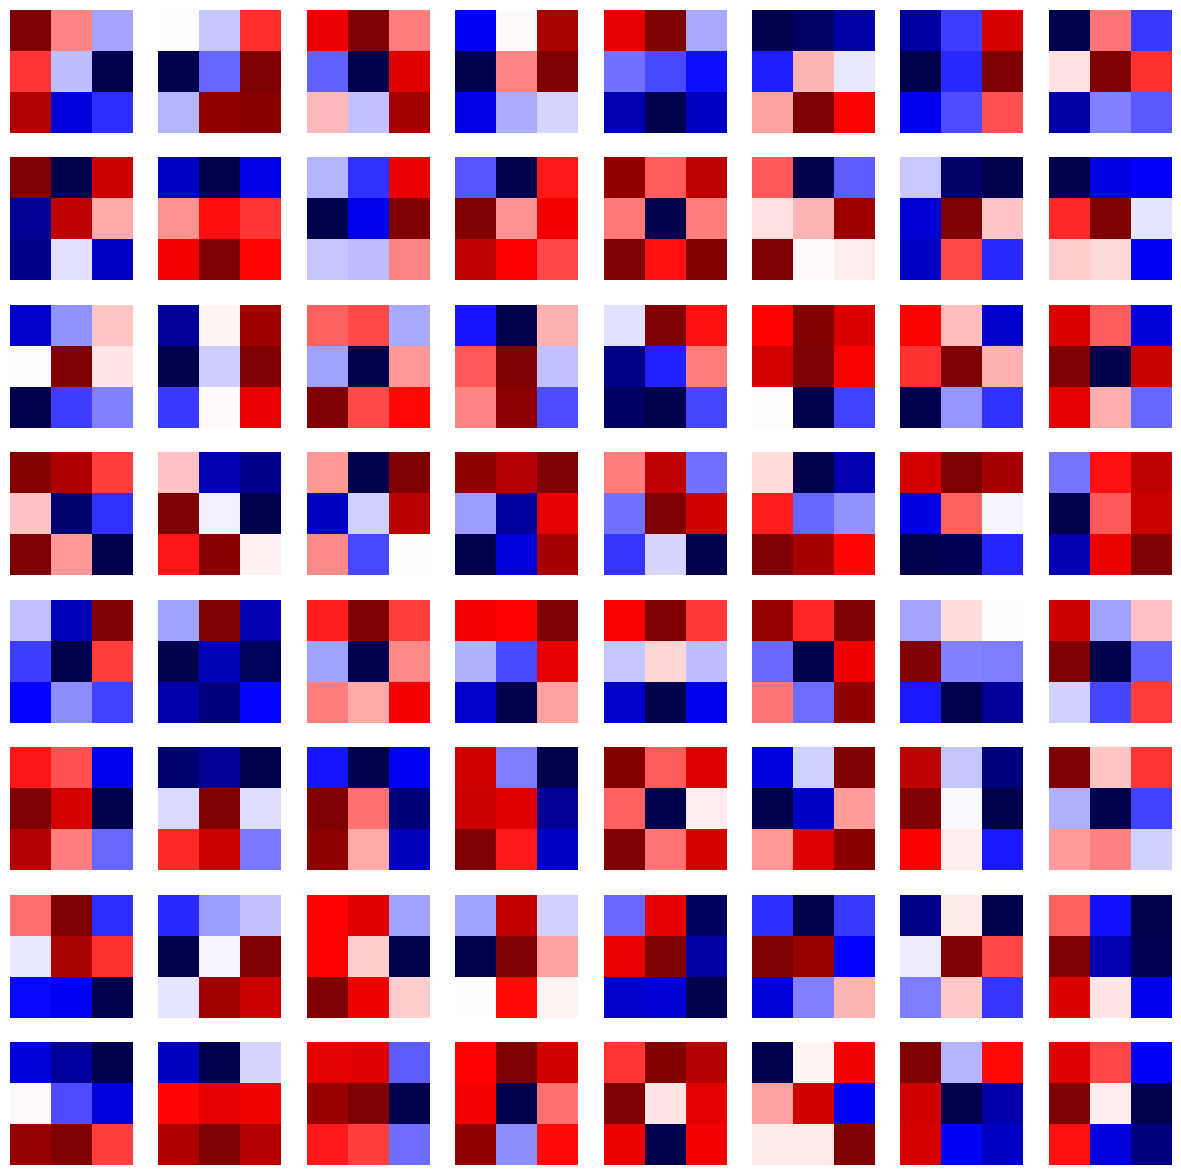

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for i in range(first_layer.shape[0]):
    plt.subplot(8, 8, i+1) #
    plt.imshow(first_layer[i, 1, :, :], cmap='seismic')
    plt.axis('off')
plt.show()

Commentaire: Même si c'est nettement moins évident que sur la première couche de convolution d'un ResNet préentraîné, on retrouve des noyaux susceptibles de calculer des gradients locaux (voir les noyaux en "drapeaux").

On peut aussi visualiser les cartes de caractéristiques :

In [ ]:
model = vgg16(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

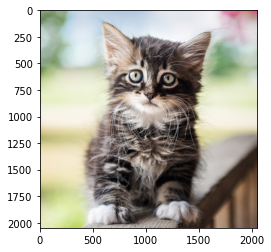

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import PILToTensor
image = Image.open("/content/cat.jpg")
plt.imshow(image)
plt.show()

In [ ]:
input = PILToTensor()(image).unsqueeze_(0).float()/256
print('Input shape : ',input.shape)
out = model.features[0](input)
print('Output shape : ',out.shape)
out = out.detach().numpy()

Input shape :  torch.Size([1, 3, 2048, 2048])
Output shape :  torch.Size([1, 64, 2048, 2048])


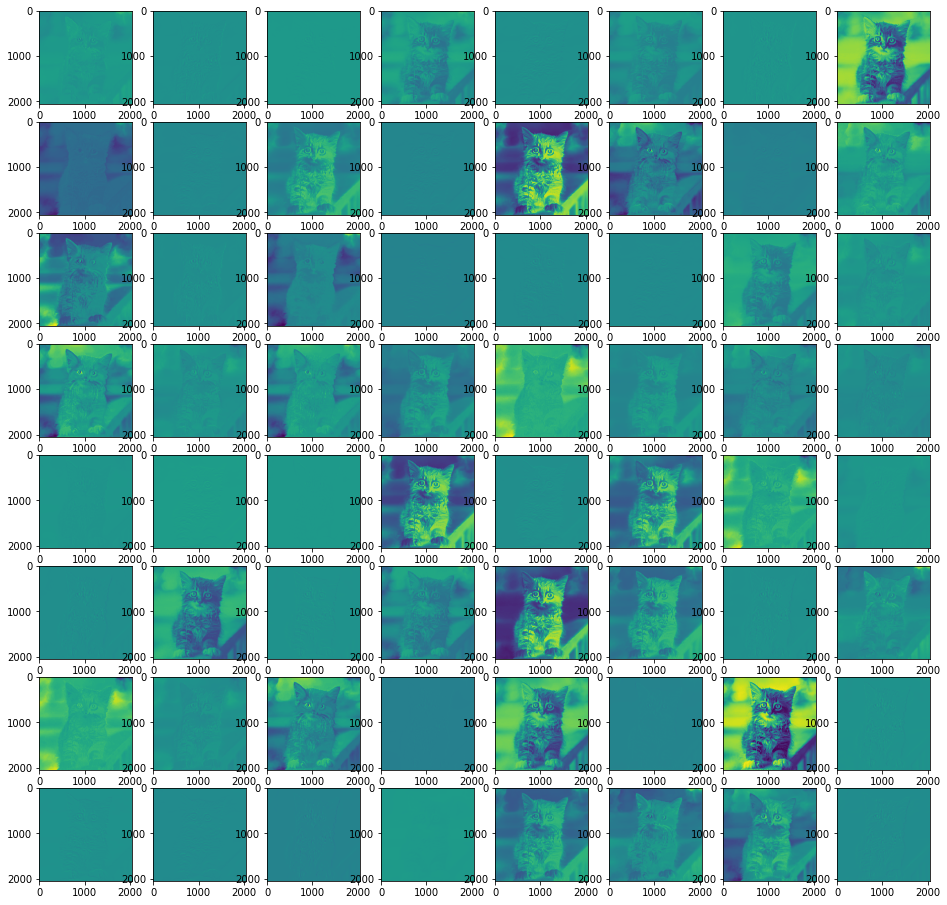

In [ ]:
fig,axs = plt.subplots(8,64//8,figsize=(2*64//8,2*8))
axs = axs.flatten()
for i in range(out.shape[1]):
  axs[i].imshow(out[0,i,:,:])


---

**Question 5** Quel est l'effet d'un dropout sur les couches complètement connectées ? Illustrer sur un perceptron à une couche avec quelques lignes de codes.

**Réponse**

---

L'utilisation des *Dropout* est une forme de régularisation qui permet de désactiver (abandonner) de manière aléatoire une partie des neurones d'une couche. Vous pouvez ajouter un Dropout après n'importe quelle couche et vous pouvez spécifier un taux de dropout, qui détermine le pourcentage de neurones désactivés dans la couche précédente.

In [ ]:
x = torch.rand((1,3))
y = torch.nn.Linear(3,6)(x)
print('fc(x) before dropout',y.detach().numpy())

# After applying dropout some outputs will be canceled to a probability of p
output = torch.nn.Dropout(p=0.5)(y) # p=0.5 means each element has a probability of 50 % to be canceled
print('After dropout', output.detach().numpy())

fc(x) before dropout [[ 0.24195445  1.6337762   0.24478924 -0.7157129   0.22436513  0.26890957]]
After dropout [[ 0.          3.2675524   0.         -1.4314258   0.44873026  0.        ]]



---

**Problème 1** Classification avec cibles bruitées

Les utilisateurs du Machine Learning font souvent face à un problème de qualité des cibles.
Dans ce court problème, on se propose de mesurer l'effet de cibles bruitées sur les performances en généralisation d'un CNN.


Pour une comparaison propre, nous allons d'abord scinder en trois jeux le dataset MNIST :


In [ ]:
import torchvision
from torchvision import datasets
import torch
from torch.utils.data import random_split, Dataset, DataLoader
root = '/content/drive/MyDrive/TP_ENM/data'

#Définition des jeux d'apprentissage:
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])


ds_trainval = datasets.MNIST(root='MNIST', download=True, train=True)
ds_test = datasets.MNIST(root='MNIST', download=True, train=False)



len_trainval = len(ds_trainval)
len_train = round(0.8 * len_trainval)
len_val = len_trainval - len_train
subset_train, subset_val = random_split(ds_trainval,
                                [len_train, len_val],
                                generator=torch.Generator().manual_seed(1))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [ ]:
#Split aléatoire en deux datasets (80% train, 20% val):
class SubDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [ ]:
ds = {}
ds['train'] = SubDataset(subset_train, tr)
ds['val'] = SubDataset(subset_val, tr)
ds['test'] = ds_test
loader = {x : DataLoader(ds[x], batch_size=32, shuffle=True, num_workers = 2) for x in ds.keys()}

**Question 6**  Quelles sont les tailles des différents jeux de données ? A quoi sert-il de fixer le générateur de nombres aléatoires dans random_split ?

**Réponse**

---

En général, on fixe le générateur de nombres aléatoires de façon à pouvoir reproduire des résultats à l'identique. Ici, on s'assure seulement que la écomposition en sous-ensembles sera la même à chaque fois qu'on relancera le code.
Noter que, comme Rachid le disait en TP, fixer la graine du générateur ne garantit pas la reproductibilité dès lors qu'on travaille sur des cartes gpu (voir la [doc](https://pytorch.org/docs/stable/notes/randomness.html) pour plus d'infos).


In [ ]:
dataset_sizes = {}
for key in ds.keys():
  print(key, len(ds[key]))
  dataset_sizes[key]=len(ds[key])

train 48000
val 12000
test 10000


---

**Question 7** Reprendre le CNN du TP1/partie3 et la fonction train_model_gpu vue au TP1/partie4.
- Ajouter une procédure de sélection de modèle à partir des performances sur le jeu de validation.
- Coder une fonction test_model_gpu() qui calcule la justesse sur le jeu de test.
- Faire tourner l'apprentissage sur 50 époques, avec l'optimiser ADAM, paramétré de manière standard.

Quelles sont les performances sur le jeu de test du modèle sélectionné ? \\


In [ ]:
device = torch.device("cuda:0")

In [ ]:
from tqdm import tqdm
def train_model_gpu(model, loss_ft, optimizer, num_epochs=1, K=1):
    save_path = f'/content/model.pth'
    acc_max = 0
    for k in range(K):
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

            phase = 'train'
            model.train()

            # initialisation des compteurs
            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in tqdm(loader[phase]):

                #on passe les inputs et les labels sur le gpu
                inputs = inputs.to(device)
                labels = labels.to(device)

                # mise à zéro des incréments dans l'optimizer
                optimizer.zero_grad()

                # calcul des sorties (proba) et des prédictions (classe)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                # fonction de coût
                loss = loss_ft(outputs, labels)

                # gradients et backprop si entraînement
                loss.backward()
                optimizer.step()

                # compteurs
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu()

            # Calcul du coût moyen et de la justesse sur l'époque
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Validation
        phase = 'val'
        model.eval()
        running_corrects = 0
        for inputs, labels in loader[phase]:
            #on passe les inputs et les labels sur le gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).cpu()

        # Calcul du coût moyen et de la justesse sur l'époque
        acc = running_corrects.double() / dataset_sizes[phase]
        print('{}: Acc: {:.4f}'.format(phase, acc))
        if acc > acc_max:
          acc_max = acc
          torch.save(model.state_dict(), save_path)

    # load the best model
    model.load_state_dict(torch.load(save_path))
    return model

In [ ]:
def test_model_gpu(model):

    phase = 'test'
    model.eval()

    # initialisation des compteurs
    running_corrects = 0

    for inputs, labels in tqdm(loader[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).cpu()

    return running_corrects.double() / dataset_sizes[phase]

In [ ]:
N = 490
import torch.nn.functional as F
import torch.nn as nn
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding =2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding =2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # ici, le log est appliqué derrière la softmax :
        return F.log_softmax(x, dim=1)

In [ ]:
model = CNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
loss_ft =  nn.CrossEntropyLoss()

model = train_model_gpu(model, loss_ft, optimizer, num_epochs=10)

Epoch 1/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.84it/s]


train Loss: 0.3735 Acc: 0.8820
Epoch 2/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 100.88it/s]


train Loss: 0.1745 Acc: 0.9471
Epoch 3/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.58it/s]


train Loss: 0.1326 Acc: 0.9592
Epoch 4/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.97it/s]


train Loss: 0.1136 Acc: 0.9654
Epoch 5/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 103.67it/s]


train Loss: 0.1002 Acc: 0.9695
Epoch 6/10
----------


100%|██████████| 1500/1500 [00:16<00:00, 93.43it/s] 


train Loss: 0.0900 Acc: 0.9719
Epoch 7/10
----------


100%|██████████| 1500/1500 [00:17<00:00, 84.33it/s]


train Loss: 0.0836 Acc: 0.9735
Epoch 8/10
----------


100%|██████████| 1500/1500 [00:16<00:00, 93.42it/s] 


train Loss: 0.0817 Acc: 0.9743
Epoch 9/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.18it/s]


train Loss: 0.0734 Acc: 0.9766
Epoch 10/10
----------


100%|██████████| 1500/1500 [00:17<00:00, 85.12it/s]

train Loss: 0.0700 Acc: 0.9778


val: Acc: 0.9893


**Question 8** Quel est l'effet de la fonction suivante sur un batch de cibles ?

**Réponse**

---

Remplacer les labels par un label aléatoire avec une proba de $p$.


In [ ]:
def flipping_label(labels, p):
  #Sélection aléatoire des composantes
  flip_probas = p * torch.ones(labels.shape)
  flip_or_not = torch.bernoulli(flip_probas) == 1
  random_labels = torch.randint(0,10,labels.shape).to(device)
  labels[flip_or_not] = random_labels[flip_or_not]
labels = torch.randint(0,10,(32,)).to(device)
print(labels)

# niveau de bruit :
p = 0.5

# Après bruitage :
flipping_label(labels, p)
print(labels)

tensor([6, 6, 4, 4, 1, 3, 9, 3, 0, 4, 3, 2, 7, 3, 9, 6, 6, 1, 0, 2, 2, 1, 8, 4,
        3, 8, 1, 1, 6, 2, 1, 3], device='cuda:0')
tensor([6, 7, 3, 4, 2, 3, 9, 0, 0, 4, 0, 4, 5, 3, 6, 6, 1, 1, 0, 2, 2, 0, 8, 4,
        0, 8, 1, 8, 4, 2, 1, 1], device='cuda:0')


**Question 9** Définir une procédure d'entraînement "bruitée" à partir de flipping_labels() (ne bruiter que la phase d'entraînement). Quel est l'effet sur les performances en fonction du niveau de bruit ?

In [ ]:
def train_model_gpu_noisy(model, loss_ft, optimizer, num_epochs=1):
    accs = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        phase = 'train'
        model.train()

        # initialisation des compteurs
        running_loss = 0.0
        running_corrects = 0


        for inputs, labels in tqdm(loader[phase]):

            #on passe les inputs et les labels sur le gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            # mise à zéro des incréments dans l'optimizer
            optimizer.zero_grad()

            # calcul des sorties (proba) et des prédictions (classe)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).cpu()
            flipping_label(labels, 0.2)
            # fonction de coût
            loss = loss_ft(outputs,labels)

            # gradients et backprop si entraînement
            loss.backward()
            optimizer.step()

            # compteurs
            running_loss += loss.item() * inputs.size(0)

        # Calcul du coût moyen et de la justesse sur l'époque
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Validation
        phase = 'val'
        model.eval()
        running_corrects = 0
        for inputs, labels in loader[phase]:
            #on passe les inputs et les labels sur le gpu
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).cpu()

        # Calcul du coût moyen et de la justesse sur l'époque
        acc = running_corrects.double() / dataset_sizes[phase]
        print('{} : Acc: {:.4f}'.format(phase, acc))
        accs += [acc]
    return model, accs

In [ ]:
model = CNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters())
loss_ft =  nn.CrossEntropyLoss()

model,accs = train_model_gpu_noisy(model, loss_ft, optimizer, num_epochs=10)

Epoch 1/10
----------


100%|██████████| 1500/1500 [00:15<00:00, 95.31it/s] 

train Loss: 1.3070 Acc: 0.8453


val : Acc: 0.9687
Epoch 2/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.34it/s]

train Loss: 1.1502 Acc: 0.9338


val : Acc: 0.9761
Epoch 3/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 102.45it/s]

train Loss: 1.1441 Acc: 0.9461


val : Acc: 0.9795
Epoch 4/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 102.75it/s]

train Loss: 1.1159 Acc: 0.9544


val : Acc: 0.9818
Epoch 5/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.26it/s]

train Loss: 1.0877 Acc: 0.9607


val : Acc: 0.9817
Epoch 6/10
----------


100%|██████████| 1500/1500 [00:15<00:00, 98.72it/s] 

train Loss: 1.0904 Acc: 0.9634


val : Acc: 0.9826
Epoch 7/10
----------


100%|██████████| 1500/1500 [00:15<00:00, 96.35it/s] 

train Loss: 1.0919 Acc: 0.9659


val : Acc: 0.9847
Epoch 8/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 100.37it/s]

train Loss: 1.0724 Acc: 0.9679


val : Acc: 0.9828
Epoch 9/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.82it/s]

train Loss: 1.0842 Acc: 0.9695


val : Acc: 0.9852
Epoch 10/10
----------


100%|██████████| 1500/1500 [00:14<00:00, 101.87it/s]

train Loss: 1.0665 Acc: 0.9704


val : Acc: 0.9852


**Question 10** (subsidiaire)
Avec une justesse de 99%, quelle est la chance de voir un modèle
se tromper sur un code postal de 5 chiffres ?  

**Réponse**

---
5 %

**Problème 2** Le chat perturbé

Dans ce problème ouvert, il s'agit d'éprouver la robustesse des prédictions d'un réseau de neurone après entraînement.
Reprendre l'image de chat du TP 1 et la bruiter de manière à ce que :
- le chat soit encore parfaitement reconnaissable
- le VGG16 (après être mis en mode évaluation) se trompe complètement  de classe.

Le code ci-dessous fournit un exemple (non trivial) où, pour toutes modifications:
- la résolution de l'image a été dégradée (61 x 64)
- une vingtaine de pixels ont été modifiés

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms

model = models.vgg16(pretrained=True)
model = model.cuda()
softmx = nn.Softmax(dim=1).cuda()
model.eval()


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import copy
# bornes sur les paramètres:
# nombre de pixels à modifier
Npix = 20
Nc = 3
bounds = np.array([(0,1), (0,1)] + [(-3., 3.) for m in range(Nc)])

# cette fonction permet de dupliquer un vecteur N fois

def repeat(x, N):
  s = x.shape
  x = x.reshape((1,*s)).repeat(N,axis=0).reshape((s[0]*N,-1))
  return np.squeeze(x)

print(bounds.shape)
bounds = repeat(bounds, Npix)
print(bounds.shape)

# image
s = 64
path = "/content/cat.jpg"
image = Image.open(path).convert("RGB")
image = image.resize((s,s))
img = transforms.ToTensor()(image)
img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
# sortie brute
img = img.unsqueeze(dim=0).cuda()

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

(5, 2)
(100, 2)


In [ ]:
# Cette fonction permet de modifier les valeurs des pixels donnés
def update_pixels(img,x):
  new_img = copy.deepcopy(img).cuda().detach()
  for j in range(Npix):
    coordx = round((s-1)*x[5*j])
    coordy = round((s-1)*x[5*j + 1])
    # la normalisation par l'écart type (std) + la moyenne assure que les valeurs données
    # aux pixels modifiés ne soient pas aberrantes
    newcolumn = torch.tensor([x[5*j + 2],x[5*j + 3],x[5*j + 4]]) * std + mean
    new_img[0, :, coordx, coordy] = newcolumn.cuda()
  return new_img

# cette fonction permet de calculer la loss sur certaines probabilités de classification
def loss_over_targets(x):
  new_img = update_pixels(img,x)
  output = softmx(model(new_img)).squeeze(dim=0)
  #loss = -torch.log(output[286:287]).mean() + torch.log(output[281:286]).mean()
  # 281,...,286 correspondent aux classes de chats
  loss = torch.log(output[281:286]).mean()
  return loss.cpu().item()


# Cette fonction permet de calculer la prediction du model l'image modifiée
def get_pred(x):
  new_img = update_pixels(img, x)
  output = softmx(model(new_img))
  pred = torch.max(output, dim = 1)[1]
  mean_proba = output[0,281:286].mean()
  return pred.item(), new_img, mean_proba.item()


In [ ]:
# exemple
x0 = np.array([0.2,0.5,1.2,-1.2,-0.3])

print(repeat(x0, Npix))
print(loss_over_targets(repeat(x0, Npix)))

[ 0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2
 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2
 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5
  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2
  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3
  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2
 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2 -1.2 -0.3  0.2  0.5  1.2
 -1.2 -0.3]
-12.612342834472656


In [ ]:
import scipy as sc
# Diffrential evolution est algorithme stochastique d'optimisation
from scipy.optimize import differential_evolution as de

# Nous allons chercher à trouver les pixels et la valeurs à modifier
# pour minimiser les probabilités de classifier l'image comme étant un caht
result = de(loss_over_targets, bounds = bounds, popsize = 400, mutation = 0.5, maxiter = 1, recombination = 0.05,  seed=1)

# print(round((s-1)*result.x[0]))
# print(round((s-1)*result.x[1]))
# print(result.x[2:])
cl_init, _, mean_proba_init = get_pred(repeat(x0,Npix))
cl, new_img, mean_proba = get_pred(result.x)
print(cl_init, mean_proba_init)
print(cl, mean_proba)
print(result.fun)


In [ ]:
def imshow(inp, title=None, save_path=None):
    if save_path is not None:
        torch.save(inp, save_path)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
print(round((s-1)*result.x[0]))
print(round((s-1)*result.x[1]))

print(result.x[2:])

cl, new_img = get_pred(result.x)
print(cl)
imshow(new_img.squeeze(dim=0).cpu())

classe prédite : 333 (hamster)


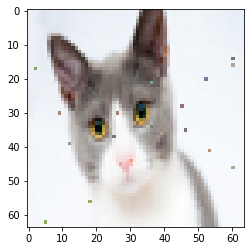

In [ ]:
## Après optimisation voici une configuration qui arrive à tromper le modèle
path = '/content/drive/MyDrive/TP_ENM_2223/disrupted_cat.pt'
dcat = torch.load(path)

imshow(dcat)

dcat = dcat.unsqueeze(dim=0).cuda()
output_dcat = softmx(model(dcat)).squeeze(dim=0)
pred_dcat = torch.max(output_dcat, dim=0)[1].item()
print("classe prédite : " + str(pred_dcat) + " (hamster)")